In [1]:
import matplotlib.pyplot as plt
import lesion
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import unet
import residual_unet
import utils as util
import torch.nn.functional as F
from sklearn.metrics import jaccard_score as jsc
device = torch.device("cuda:0")
import ECE

In [2]:
class ToTensor_segmap(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, segmap):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        # In this case, Channels is 1, so there is no need to swap since data is in HxW      
  
        segmap = np.array(segmap)
        return torch.from_numpy(segmap) / 255

image_transform = transforms.Compose([
        transforms.RandomGrayscale(1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])
seg_transform = ToTensor_segmap()

In [3]:
batch_size = 2
dataset = lesion.LesionDataset("data",folder_name = 'val',joint_transform=False,img_transform=image_transform, seg_transform=seg_transform,verbose = True)
loader = DataLoader(dataset, batch_size=batch_size,shuffle=False, num_workers=4)

In [4]:

model1 = torch.load("models/" + "gate_all.pth")
model2 =torch.load("models/" + "gate_all_1.pth")
model3 =torch.load("models/" + "gate_all_2.pth")
model4 =torch.load("models/" + "gate_all_3.pth")
model5 =torch.load("models/" + "gate_all_4.pth")

model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()


DataParallel(
  (module): res_unet_gate(
    (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout2d(p=0.3, inplace=False)
    (preprocess): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (down1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(


In [5]:
def apply_dropout(m):
    if type(m) == nn.Dropout2d:
        m.train()
        
#T is the number of times to sample to approximate the posterior predictive distribution
#Assume model in eval mode
def pred_mean(loader,model,T,bayesian = True):
    total = len(loader)*batch_size
    if(bayesian):
        print("Bayesian Mode")
        model.apply(apply_dropout)
    preds = np.zeros((total, 2, 512, 1024))
    var = np.zeros((total, 2, 512, 1024))
    targets = np.zeros((total, 512, 1024))
    for iteration in range(T):
        for i,data in enumerate(loader):
                image = data[0].to(device)
                m = nn.Softmax2d()
                output = model(image)
                output = m(output)
                segmap = data[1].numpy()
                preds[batch_size*i:batch_size*i + batch_size] += output.detach().cpu().numpy()
                if(iteration==0):
                    targets[batch_size*i:batch_size*i + batch_size] = segmap
    mean = preds / T
    entropy = -1*(mean[:,0,]*np.log(mean[:,0,]) + ((mean[:,1,])*np.log(mean[:,1,])))
    
    return mean,entropy,targets
    
    
    

    
     
    

In [6]:
pred_temp = None
entropy_temp = None

pred,var,targets = pred_mean(loader,model1,5)
pred_temp = pred
entropy_temp = var

pred,var,_ = pred_mean(loader,model2,5)
pred_temp += pred
entropy_temp += var

pred,var,_ = pred_mean(loader,model3,5)
pred_temp += pred
entropy_temp += var

pred,var,_ = pred_mean(loader,model4,5)
pred_temp += pred
entropy_temp += var

pred,var,_ = pred_mean(loader,model5,5)
pred_temp += pred
entropy_temp += var

Bayesian Mode
Bayesian Mode
Bayesian Mode
Bayesian Mode
Bayesian Mode


In [7]:
pred_temp/=5
entropy_temp /=5


In [8]:
confidence = pred_temp.max(axis=1)
avg_conf = 0
for i in range(150):
    avg_conf += confidence[i].mean()
avg_conf/=150
avg_conf

0.94671168532378147

In [9]:
avg_uncertainty = 0
#150 images in test set
for i in range(150):
    avg_uncertainty+= entropy_temp[i].mean()
avg_uncertainty /=150
avg_uncertainty

0.12302992224697855

In [10]:
batch_size = 2
dataset = lesion.LesionDataset("data",folder_name = 'test',joint_transform=False,img_transform=image_transform, seg_transform=seg_transform,verbose = True)
loader = DataLoader(dataset, batch_size=batch_size,shuffle=False, num_workers=4)

In [11]:
pred_temp = None
entropy_temp = None # entropy for test set

pred,var,targets = pred_mean(loader,model1,5)
pred_temp = pred
entropy_temp = var

pred,var,_ = pred_mean(loader,model2,5)
pred_temp += pred
entropy_temp += var

pred,var,_ = pred_mean(loader,model3,5)
pred_temp += pred
entropy_temp += var

pred,var,_ = pred_mean(loader,model4,5)
pred_temp += pred
entropy_temp += var

pred,var,_ = pred_mean(loader,model5,5)
pred_temp += pred
entropy_temp+= var

pred_temp/=5
entropy_temp /=5


Bayesian Mode
Bayesian Mode
Bayesian Mode
Bayesian Mode
Bayesian Mode


In [12]:
pred = pred_temp.argmax(axis=1) #test prediction
cm = np.copy(entropy_temp)
upper = np.nonzero(cm > avg_uncertainty)
lower = np.nonzero(cm <= avg_uncertainty)
cm[upper] = 0
cm[lower]=1

In [13]:

def get_score(pred,t):
    jaccard = 0
    total = len(loader)*batch_size
    for i in range(total):
        jaccard += jsc(pred[i].reshape(-1),t[i].reshape(-1))
    jaccard /= total
    
    return jaccard,np.count_nonzero(pred==t)/pred.reshape(-1).shape[0]
        

In [14]:
jaccard,accuracy =get_score(pred,targets)
print("Jaccard Score:{},  Accuracy:{} ".format(jaccard,accuracy))

Jaccard Score:0.7089989264899831,  Accuracy:0.91730775197347 


In [15]:
'''
P(accurate|certain)
'''
def ac(gt,pred,cm):
    #gt = groundtruth, pred = predictions, cm = certainty map
    loc = np.nonzero(cm==1) # location of certain pixels
    gt = gt[loc]
    pred = pred[loc]
    p = np.count_nonzero(gt == pred) # number of accurate pixels given they are certain
    return p/np.count_nonzero(cm==1)
'''
p(uncertain|inaccurate)
'''
def uia(gt,pred,cm):
    loc = np.nonzero(gt != pred) # location of inaccurate pixels
    cm = cm[loc]
    return np.count_nonzero(cm==0)/np.count_nonzero(gt!=pred)

In [16]:
pac = ac(targets,pred,cm) #prob of accurate given certain
puia =uia(targets,pred,cm) #prob of uncertain given inaccurate

In [17]:
print("Prob of accurate given certain is:{} ".format(pac))
print("Prob of uncertain given inaccurate is:{} ".format(puia))

Prob of accurate given certain is:0.983403604815615 
Prob of uncertain given inaccurate is:0.8602889154434067 


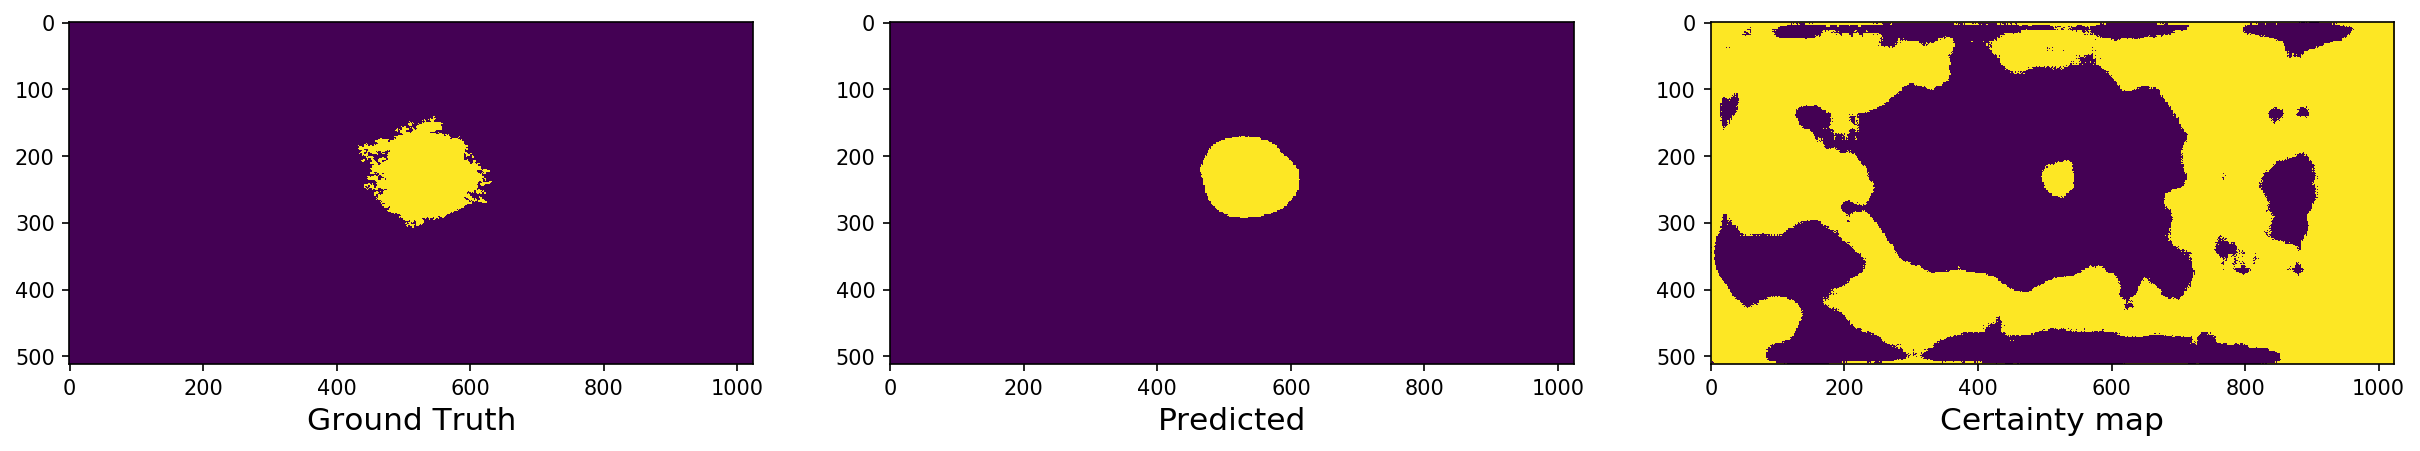

In [20]:
i = 5
fig = plt.figure(figsize=(20,20), dpi=150)
ax1 = fig.add_subplot(1,3,1)
ax1.set_xlabel("Ground Truth",fontsize = 15)
ax1.imshow(targets[i])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(pred[i])
ax2.set_xlabel("Predicted",fontsize = 15)
ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel("Certainty map",fontsize = 15)
ax3.imshow(cm[i])
